In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from scipy import signal
from apis.imaging_classes import save_disp_imgs,bootstrap_disp
from modules.utils import extract_ridge_ref_idx,plot_disp_curves,win_avg_psd
from modules.car_tracking_utils import plot_data
import random
import scipy
from tqdm.notebook import tqdm

# Load saved surface wave windows associated with vehicle states and speeds

In [2]:
# Define the file name using an f-string to include the value of _x0: pivot.
_x0 = 700
tracking_offset = 200
_start_x = _x0 - tracking_offset
_end_x = _x0 + tracking_offset
file_name = f"data/sw_data/{_x0}.pkl"

# Open the file in binary read mode
with open(file_name, "rb") as f:
    # Load the pickled data from the file.
    windows_all = pickle.load(f)  # Load the 'windows_all' surface wave window data from the file.
    das_veh_states = pickle.load(f)  # Load the 'das_veh_states' data from the file.
    veh_speed = pickle.load(f)  # Load the 'veh_speed' data from the file.

# Get surface wave windows with different vehicle weights

## Use majority vehicle weights

In [ ]:
# Calculate the mean along the first axis
das_veh_states_mean = []
for das_veh in das_veh_states:
    mean_tmp = signal.detrend(signal.savgol_filter(das_veh.mean(0),101,3))
    mean_tmp = mean_tmp-mean_tmp[0]
    das_veh_states_mean.append(mean_tmp)
# Calculate the peaks of the mean values.
peaks = np.max(np.abs(das_veh_states_mean), 1)

In [ ]:
# Create a histogram of vehicle speeds.
fig = plt.figure(figsize=(5, 3))
plt.hist(peaks, bins=100)
plt.xlabel('Peak')
plt.ylabel('Count')
# Create a histogram of vehicle speeds.
hist, bins = np.histogram(peaks, bins=100)
# Find the bin with the highest frequency (the mode).
mode_peak = bins[np.argmax(hist)]
# Calculate the standard deviation of the vehicle speeds.
sigma = np.std(peaks)
# Define threshold values based on one sigma away from the mode.
lower_limit = mode_peak - 0.3*sigma
upper_limit = mode_peak + 0.3*sigma
# Define a condition to select speeds within one sigma of the mode.
peak_idx = np.where((peaks >= lower_limit) & (peaks <= upper_limit))[0]

# Plot vertical lines to mark the threshold values.
plt.axvline(lower_limit, color='r', linestyle='--', label=f'Lower Threshold ({lower_limit:.2f} m/s)')
plt.axvline(upper_limit, color='k', linestyle='--', label=f'Upper Threshold ({upper_limit:.2f} m/s)')
# Create a legend to label the threshold lines.
plt.legend()

# Filter das_veh_states_mean and windows_all_rm to only include elements with matching indices in speed_idx.
veh_speed = np.array([i for j, i in enumerate(veh_speed) if j in peak_idx])
das_veh_states = [i for j, i in enumerate(das_veh_states) if j in peak_idx]
windows_all = [i for j, i in enumerate(windows_all) if j in peak_idx]

## Spliting small, mid, and large speed vehicles

Number of Fast vehiles: 330
Number of Mid vehiles: 1442
Number of Slow vehiles: 336


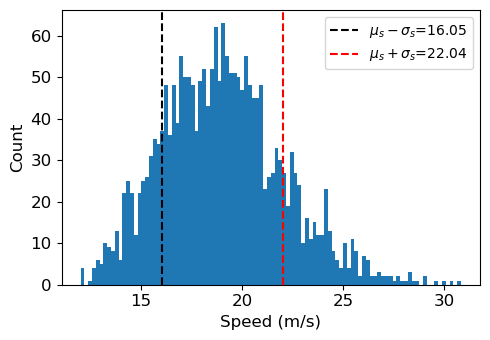

In [5]:
# Create a histogram of the speed.
fig = plt.figure(figsize=(5, 3.5))
n, bins, patches = plt.hist(veh_speed, bins=100)
plt.xlabel('Speed (m/s)',fontsize=12)
plt.ylabel('Count',fontsize=12)

# Define threshold values based on one sigma away from the mean.
threshold_1 = np.mean(veh_speed) + np.std(veh_speed)
threshold_2 = np.mean(veh_speed) - np.std(veh_speed)
# Plot vertical lines to mark the thresholds.
plt.axvline(threshold_2, color='k', linestyle='--', label=f'$\mu_s-\sigma_s$={threshold_2:.2f}')
plt.axvline(threshold_1, color='r', linestyle='--', label=f'$\mu_s+\sigma_s$={threshold_1:.2f}')
# Create a legend to label the threshold lines.
plt.legend()

# Classify speed into fast, midspeed, and slow based on the conditions.
fast_idx = np.where(veh_speed > threshold_1)[0]
mid_idx = np.where((veh_speed <= threshold_1) & (veh_speed > threshold_2))[0]
slow_idx = np.where(veh_speed <= threshold_2)[0]
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig(f'figures/{_x0}/hist_speed.pdf', format='pdf')

# Print the number of elements in each category.
print(f'Number of Fast vehiles: {len(fast_idx)}')
print(f'Number of Mid vehiles: {len(mid_idx)}')
print(f'Number of Slow vehiles: {len(slow_idx)}')

In [6]:
windows_fast = []  
windows_mid = []  
windows_slow = [] 
speed_fast = []  
speed_mid = []  
speed_slow = [] 
state_fast = []  
state_mid = []  
state_slow = [] 

# Iterate through fast_idx, mid_idx, and slow_idx to collect corresponding surface wave windows.
for k in fast_idx:
    windows_fast.append(windows_all[k])
    speed_fast.append(veh_speed[k])
    state_fast.append(das_veh_states_mean[k])
for k in mid_idx:
    windows_mid.append(windows_all[k])
    speed_mid.append(veh_speed[k])
    state_mid.append(das_veh_states_mean[k])
for k in slow_idx:
    windows_slow.append(windows_all[k])
    speed_slow.append(veh_speed[k])
    state_slow.append(das_veh_states_mean[k])

## Visualize different weights vehicles in time domain

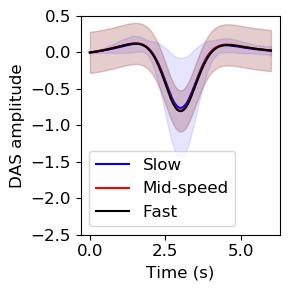

In [7]:
fig = plt.figure(figsize=(3, 3))
t_axis_tmp = np.arange(0,1500/250,1/250)
mean_slow = np.mean(state_slow,axis=0)
std_slow = np.std(state_slow,axis=0)
ci_slow = 1.96 * std_slow / np.sqrt(len(state_slow))

mean_mid = np.mean(state_mid,axis=0)
std_mid = np.std(mean_mid,axis=0)
ci_mid = 1.96 * std_mid / np.sqrt(len(state_mid))

mean_fast = np.mean(state_fast,axis=0)
std_fast = np.std(mean_fast,axis=0)
ci_fast = 1.96 * std_fast / np.sqrt(len(state_fast))

plt.plot(t_axis_tmp, mean_slow,'b',label='Slow')
plt.fill_between(t_axis_tmp, mean_slow - std_slow, mean_slow + std_slow, color='blue', 
                 alpha=0.1)

plt.plot(t_axis_tmp, mean_mid,'r',label='Mid-speed')
plt.fill_between(t_axis_tmp, mean_mid - std_mid, mean_mid + std_mid, color='red', 
                 alpha=0.1)

plt.plot(t_axis_tmp, mean_fast,'k',label='Fast')
plt.fill_between(t_axis_tmp, mean_fast - std_fast, mean_fast + std_fast, color='black', 
                 alpha=0.1)
plt.legend(fontsize=12)
plt.ylim([-2.5,0.5])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Time (s)',fontsize=12)
plt.ylabel('DAS amplitude',fontsize=12)
plt.tight_layout()
plt.savefig(f'figures/{_x0}/speed_time.pdf', format='pdf')

25.0146628048


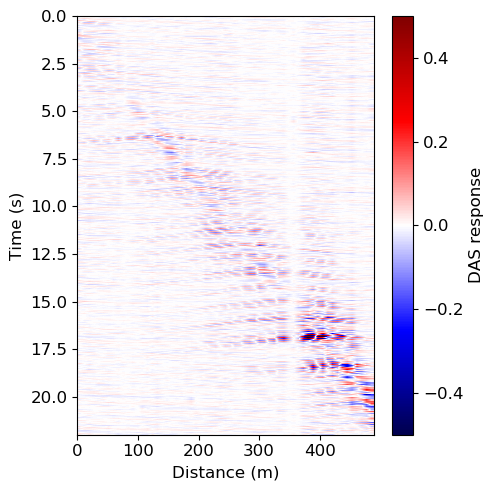

In [8]:
idx = 50
win_toplot = windows_fast[idx]
print(speed_fast[idx])
data_tmp, x_axis_tmp, t_axis_tmp = win_toplot.data, win_toplot.x_axis, win_toplot.t_axis
plot_data(data_tmp, x_axis_tmp-x_axis_tmp[0], t_axis_tmp-t_axis_tmp[0], 
          vmax=0.5, figsize=(5, 5), save_path=f'figures/{_x0}/fast_win.pdf')

20.1339249356


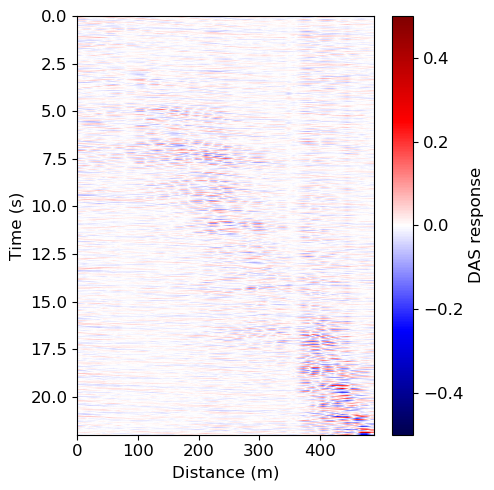

In [9]:
idx = 28
win_toplot = windows_mid[idx]
print(speed_mid[idx])
data_tmp, x_axis_tmp, t_axis_tmp = win_toplot.data, win_toplot.x_axis, win_toplot.t_axis
plot_data(data_tmp, x_axis_tmp-x_axis_tmp[0], t_axis_tmp-t_axis_tmp[0], 
          vmax=0.5, figsize=(5, 5), save_path=f'figures/{_x0}/midspeed_win.pdf')

15.8025725841


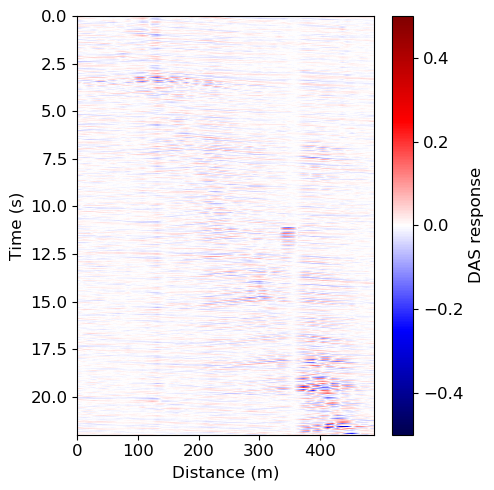

In [10]:
idx = 20
win_toplot = windows_slow[idx]
print(speed_slow[idx])
data_tmp, x_axis_tmp, t_axis_tmp = win_toplot.data, win_toplot.x_axis, win_toplot.t_axis
plot_data(data_tmp, x_axis_tmp-x_axis_tmp[0], t_axis_tmp-t_axis_tmp[0], 
          vmax=0.5, figsize=(5, 5), save_path=f'figures/{_x0}/slow_win.pdf')

# Spectrum

In [11]:
def win_avg_psd(win_spectrum,fs,nperseg=2048):
    f, Pxx = signal.welch(win_spectrum[0].data[0,:], fs, nperseg=nperseg)
    Pxxs = np.zeros((len(win_spectrum),Pxx.shape[0]))
    for i in range(len(win_spectrum)):
        n = 0
        sw_data = win_spectrum[i].data
        Pxxs_ = np.zeros(Pxx.shape)
        for j in range(sw_data.shape[0]):
            n+=1
            f, Pxx = signal.welch(sw_data[j,:], fs, nperseg=nperseg)
            Pxxs_+=Pxx
        Pxxs[i,:] = Pxxs_/n    
    Pxx_avg = np.mean(Pxxs,axis=0)
    return f,Pxx_avg,Pxxs,

In [12]:
f_fast,Pxx_avg_fast,Pxxs_fast = win_avg_psd(windows_fast,250)
f_mid,Pxx_avg_mid,Pxxs_mid = win_avg_psd(windows_mid,250)
f_slow,Pxx_avg_slow,Pxxs_slow = win_avg_psd(windows_slow,250)

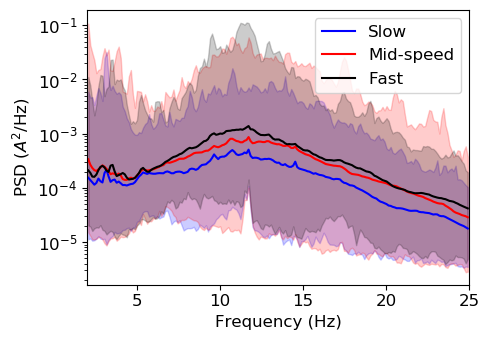

In [13]:
fig = plt.figure(figsize=(5, 3.5))
Pxx_low_slow = np.min(Pxxs_slow,axis=0)
Pxx_upp_slow = np.max(Pxxs_slow,axis=0)
plt.semilogy(f_slow[(f_slow>=2)&(f_slow<=25)], Pxx_avg_slow[(f_slow>=2)&(f_slow<=25)],'b',label='Slow')
plt.fill_between(f_slow[(f_slow>=2)&(f_slow<=25)], 
                 Pxx_low_slow[(f_slow>=2)&(f_slow<=25)], 
                 Pxx_upp_slow[(f_slow>=2)&(f_slow<=25)], 
                 color='b', alpha=0.2)

Pxx_low_mid = np.min(Pxxs_mid,axis=0)
Pxx_upp_mid = np.max(Pxxs_mid,axis=0)
plt.semilogy(f_mid[(f_mid>=2)&(f_mid<=25)], Pxx_avg_mid[(f_mid>=2)&(f_mid<=25)],'r',label='Mid-speed')
plt.fill_between(f_mid[(f_mid>=2)&(f_mid<=25)], 
                 Pxx_low_mid[(f_mid>=2)&(f_mid<=25)], 
                 Pxx_upp_mid[(f_mid>=2)&(f_mid<=25)], 
                 color='r', alpha=0.2)

Pxx_low_fast = np.min(Pxxs_fast,axis=0)
Pxx_upp_fast = np.max(Pxxs_fast,axis=0)
plt.semilogy(f_fast[(f_fast>=2)&(f_fast<=25)], Pxx_avg_fast[(f_fast>=2)&(f_fast<=25)],'k',label='Fast')
plt.fill_between(f_fast[(f_fast>=2)&(f_fast<=25)], 
                 Pxx_low_fast[(f_fast>=2)&(f_fast<=25)], 
                 Pxx_upp_fast[(f_fast>=2)&(f_fast<=25)], 
                 color='k', alpha=0.2)
plt.xlabel('Frequency (Hz)',fontsize=12)
plt.ylabel('PSD ($A^2$/Hz)',fontsize=12)
plt.xlim([2,25])
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'figures/{_x0}/speed_PSD.pdf', format='pdf')

# Imaging for different speeds

## Plot

figures/700/sg_fast_cars.pdf has saved...
saving figures/700/disp_fast_cars_no_norm.pdf...
saving figures/700/disp_fast_cars_no_enhance.pdf...
figures/700/sg_midspeed_cars.pdf has saved...
saving figures/700/disp_midspeed_cars_no_norm.pdf...
saving figures/700/disp_midspeed_cars_no_enhance.pdf...
figures/700/sg_slow_cars.pdf has saved...
saving figures/700/disp_slow_cars_no_norm.pdf...
saving figures/700/disp_slow_cars_no_enhance.pdf...


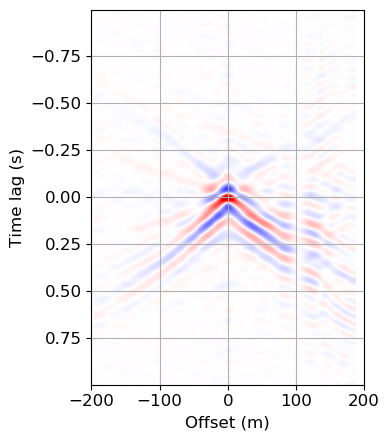

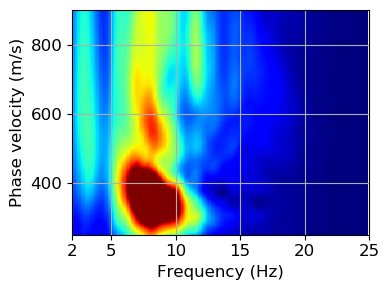

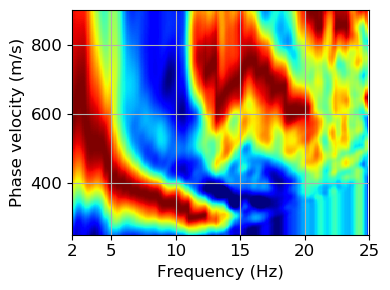

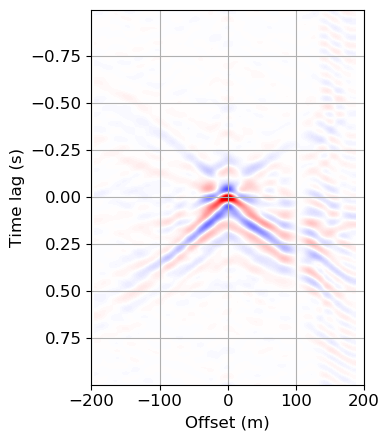

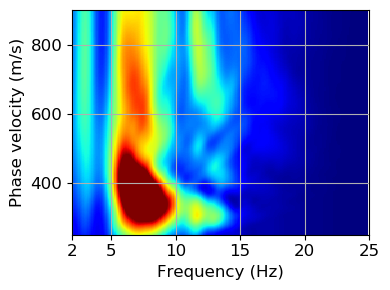

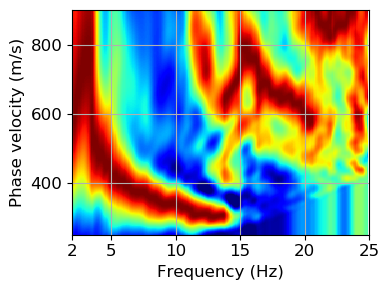

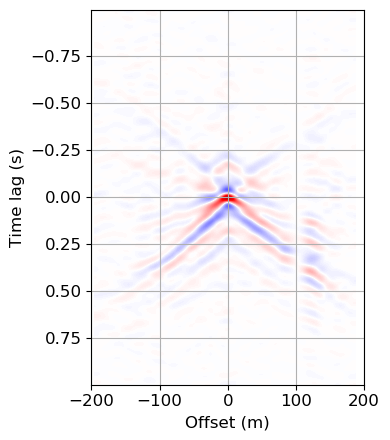

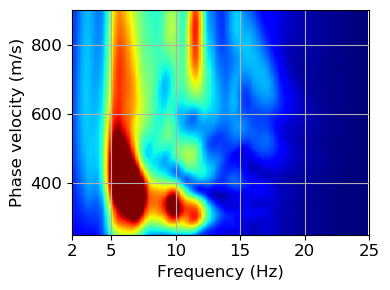

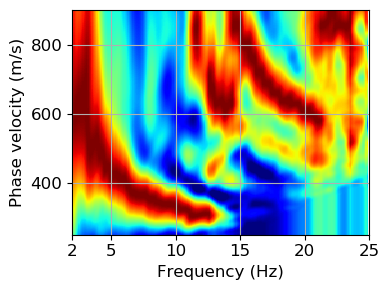

In [14]:
_min_win = np.min([len(windows_fast),len(mid_idx),len(windows_slow)])
images_fast = save_disp_imgs(windows_fast, 'fast', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')

sample = random.sample(range(len(windows_mid)), len(windows_fast))
windows_mid_sample = [windows_mid[idx] for idx in sample]
images_mid = save_disp_imgs(windows_mid_sample, 'midspeed', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')

sample = random.sample(range(len(windows_slow)), len(windows_fast))
windows_slow_sample = [windows_slow[idx] for idx in sample]
images_slow = save_disp_imgs(windows_slow_sample, 'slow', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')

## Save image files

In [33]:
file_name = f'data/saved_disp/{_x0}_images_speeds.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(images_fast, file)
    pickle.dump(images_mid, file)
    pickle.dump(images_slow, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "data/saved_disp/700_images_speeds.pkl"


## Bootstrapping


In [14]:
bt_times = 30
bt_size = 60
sigma = [25,50,50,50]
ref_freq_idx = [80,130,170,170]
freq_lb = [2.5,10,14,16]
freq_ub = [14,15,19,20]
mode1_vel = [530,470,450,430,410,391]
mode1_freq = [10,12,13,14,15,16]
mode1_f = scipy.interpolate.interp1d(mode1_freq, mode1_vel)
mode2_vel = [630,583,550,520,500,490]
mode2_freq = [14,15,16,17,18,19]
mode2_f = scipy.interpolate.interp1d(mode2_freq, mode2_vel)
mode3_vel = [745,690,657,626,600,580]
mode3_freq = [16,17,18,19,20,21]
mode3_f = scipy.interpolate.interp1d(mode3_freq, mode3_vel)
vel_ref = [None,mode1_f,mode2_f,mode3_f]
# ridge_vel_fast,freqs = bootstrap_disp(windows_fast,bt_size,bt_times,sigma,
#                                        _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
# ridge_vel_mid,_ = bootstrap_disp(windows_mid,bt_size,bt_times,sigma,
#                                        _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
# ridge_vel_slow,_ = bootstrap_disp(windows_slow,bt_size,bt_times,sigma,
#                                        _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)

In [39]:
tmp_idx = [0,3]
_ = plot_disp_curves(freqs,[freq_lb[i] for i in tmp_idx],
                     [freq_ub[i] for i in tmp_idx], [ridge_vel_fast[i] for i in tmp_idx],
                     fig_save=f'figures/{_x0}/fast_disp.pdf')
tmp_idx = [0,2,3]
_ = plot_disp_curves(freqs,[freq_lb[i] for i in tmp_idx],
                     [freq_ub[i] for i in tmp_idx], [ridge_vel_mid[i] for i in tmp_idx],
                     fig_save=f'figures/{_x0}/midspeed_disp.pdf')
_ = plot_disp_curves(freqs,[freq_lb[i] for i in tmp_idx],
                     [freq_ub[i] for i in tmp_idx], [ridge_vel_slow[i] for i in tmp_idx],
                     fig_save=f'figures/{_x0}/slow_disp.pdf')

In [23]:
file_name = f'data/{_x0}_speeds.npz'
# np.savez(file_name, freqs=freqs, freq_lb=freq_lb, freq_ub=freq_ub, 
#          vels_fast=ridge_vel_fast, 
#          vels_mid=ridge_vel_mid, 
#          vels_slow=ridge_vel_slow)
tmp = np.load(file_name,allow_pickle=True)
freqs = tmp['freqs']
freq_lb = tmp['freq_lb']
freq_ub = tmp['freq_ub']
vels_fast = tmp['vels_fast']
vels_mid = tmp['vels_mid']
vels_slow = tmp['vels_slow']

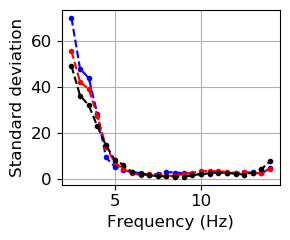

In [24]:
plt.figure(figsize=(3,2.5))
plt.plot(freqs[(freqs>=freq_lb[0])&(freqs<=freq_ub[0])][::5], 
         np.std(np.stack(vels_slow[0]),axis=0)[::5],'.--b',label='Slow')
plt.plot(freqs[(freqs>=freq_lb[0])&(freqs<=freq_ub[0])][::5], 
         np.std(np.stack(vels_mid[0]),axis=0)[::5],'.--r',label='Mid-speed')    
plt.plot(freqs[(freqs>=freq_lb[0])&(freqs<=freq_ub[0])][::5], 
         np.std(np.stack(vels_fast[0]),axis=0)[::5],'.--k',label='Fast')
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Standard deviation', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()
plt.tight_layout()
plt.savefig(f'figures/{_x0}/freq_conv_speeds.svg',format='svg')

## Convergence test


In [17]:
def convergence_test(max_sample_num,windows,bt_times,sigma,
                     x0,start_x,end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref):
    ridge_vel_std = np.empty((len(freq_lb),max_sample_num))
    for bt_size in tqdm(range(1,max_sample_num+1)):
        ridge_vel,freqs = bootstrap_disp(windows,bt_size,bt_times,sigma,x0,start_x,end_x,
                                         ref_freq_idx,freq_lb,freq_ub,vel_ref)
        for mode in range(len(freq_lb)):
            ridge_vel_std[mode,bt_size-1] = np.sum(np.std(ridge_vel[mode],axis=0))
    return ridge_vel_std


In [75]:
bt_sample_num = 60
ridge_vel_fast_std = convergence_test(bt_sample_num,windows_fast,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_mid_std = convergence_test(bt_sample_num,windows_mid,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_slow_std = convergence_test(bt_sample_num,windows_slow,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [25]:
with open('data/diff_speed_convergence.pkl', 'rb') as f: 
    ridge_vel_slow_std, ridge_vel_mid_std, ridge_vel_fast_std = pickle.load(f)

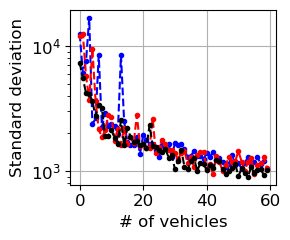

In [26]:
for mode in [0]:
    plt.figure(figsize=(3,2.5))
    plt.semilogy(ridge_vel_slow_std[mode],'.--b',label='Slow')
    plt.semilogy(ridge_vel_mid_std[mode],'.--r',label='Mid-speed')
    plt.semilogy(ridge_vel_fast_std[mode],'.--k',label='Fast')
    plt.xlabel('# of vehicles', fontsize=12)
    plt.ylabel('Standard deviation', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
#     plt.ylim([])
#     plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'figures/{_x0}/mode{mode+1}_speed.svg', format='svg')

In [77]:
# with open('data/diff_speed_convergence.pkl', 'wb') as f: 
#     pickle.dump([ridge_vel_slow_std, ridge_vel_mid_std, ridge_vel_fast_std], f)